# Analyse des données DLS de Ag 40nm

Il s'agit de données prises au tout début de l'installation de la DLS dans la salle de manip en mai-juin 2018. On ne sait pas encore exactement ce que l'on fait. 
Il s'agit aussi de la première analyse de telle données.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit 
import os
%matplotlib inline

In [164]:
# os.chdir(r'C:\Users\MatthieuL\Documents\data\2018_05_24 deuxieme Calibration DLS\Arg')
# rawdata = np.loadtxt("result_Ag_40nm_HeNe_PolarRectVert.txt")

# os.chdir(r'C:\Users\MatthieuL\Documents\data\2018_05_24 deuxieme Calibration DLS\Or')
# rawdata = np.loadtxt("result_Au80nm_HeNe_PolarVert.txt")

os.chdir(r'C:\Users\MatthieuL\Documents\data\2018_05_24 deuxieme Calibration DLS\Fluo_3xdilue')
rawdata = np.loadtxt("result_Fluo_HeNe_PolarVert.txt")


rawdata = np.transpose(rawdata)
angle = rawdata[0]
cps = rawdata[1]
correlationTime = rawdata[2]
Beta = rawdata[3]
mu2 = rawdata[4]

deltaTheta = 0.5

## Evolution angulaire de l'intensité

Les particules sont assez petites par rapport à la longueur d'onde pour que seul reste les effets due à la taille du volume d'étude. Ce dernier varie comme :
$$
V = \dfrac{1}{\sin^2 \theta}
$$

En effet, on affaire à un parrallélograme de base $w_2^2 \sin^2 \theta$ et de hauteur $w_1$

[[Model]]
    Model(volumeEtude)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 21
    # variables        = 2
    chi-square         = 1.3133e+11
    reduced chi-square = 6.9119e+09
    Akaike info crit   = 477.684969
    Bayesian info crit = 479.774014
[[Variables]]
    I0:  163781.161 +/- 40787.8473 (24.90%) (init = 21000)
    C:  -138623.328 +/- 60663.0792 (43.76%) (init = 20000)
[[Correlations]] (unreported correlations are < 0.100)
    C(I0, C) = -0.954



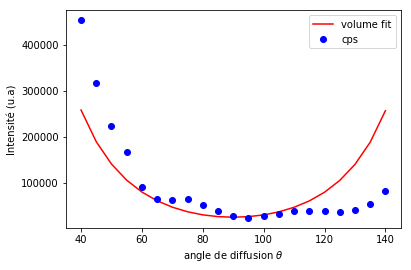

In [165]:
def volumeEtude(x, I0, C):
    return I0/(np.sin(x*3.14/180)**2) + C


gmodel = lmfit.Model(volumeEtude)
result = gmodel.fit(cps, x=angle, I0=21000, C = 20000)
print(result.fit_report())
fig = plt.figure()
plt.plot(angle, result.best_fit, 'r-', label="volume fit")
plt.plot(angle, cps, 'bo', label="cps")

plt.xlabel(r"angle de diffusion $\theta$")
plt.ylabel("Intensité (u.a)")
plt.legend()
plt.savefig("Ag_40nm_I_de_theta.png")

## Temps de correlation

Le temps de corrélation est le temps pour qu'un réseau de Brag avec le vecteur d'onde $\mathbf{q}$ se forme et disparaisse.

Tout calcul fait :
$$
q =  \dfrac{4 \pi n}{\lambda} \sin \left( \dfrac{\theta}{2} \right)
$$

La courbe de corrélation est fitté dans un premier par une expoentielle décroissante de la forme :
$$
G(\tau) = B + \beta \exp - \tau/\tau_c
$$
avec :
$$
\tau_c = \dfrac{1}{2 D} \dfrac{1}{q^2}
$$
la pente de la courbe $\tau_c$ vs $\dfrac{1}{q^2}$ vaut donc $1/2D$ 
et Stokes Eisntien donne :
$$
D = \dfrac{k_B T}{6 \pi \eta r}
$$

D'un point de vue unité, je prefere mettre $q$ en $\mu m^{-1}$, comme cela je vois de quoi on parle. On va donc avoir $D$ en $\mu m^2 \cdot s^{-1}$



r moyen : 441.032


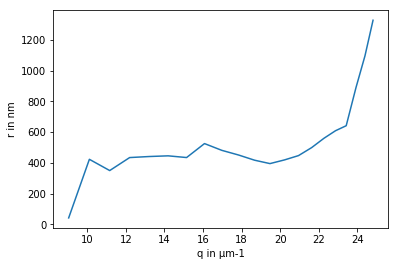

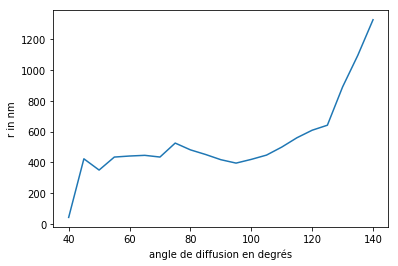

D : 6.654637E-07 µm^2 µs-1
r nm : 3.267458E+02


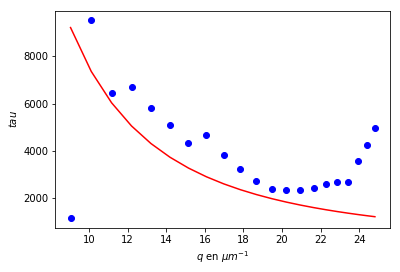

D : 1.744661E-06 µm^2 s-1
D : 1.744661E-18 m^2 s-1
r nm : 1.246302E+08


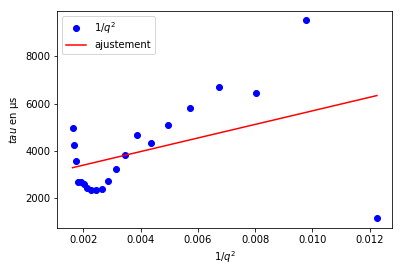

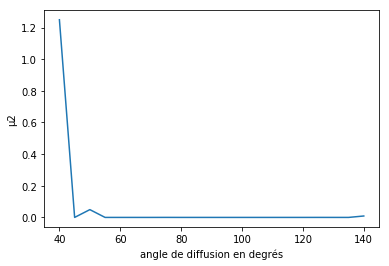

In [167]:
from decimal import Decimal

def radius_from_Stokes_Einstein(D_micron_square, T=297, eta=1E-3):
    k_B = 1.38E-23
    return k_B * T / (6 * np.pi * eta * D_micron_square*1E-12) * 1E9

# in µm
lambda_laser = 0.6328
q = 4 * np.pi * 1.33 / lambda_laser * np.sin(angle*np.pi/180/2)

array_D = 1/(2*correlationTime*q**2)
array_r_nm = radius_from_Stokes_Einstein(array_D*1E6)

print("r moyen : %.3f" % np.mean(array_r_nm[2:-6]))

plt.plot(q, array_r_nm)
plt.xlabel("q in µm-1")
# plt.title("Calcul de r à partir des temps de corrélation")
plt.ylabel("r in nm")
plt.show()


plt.plot(angle, array_r_nm)
plt.xlabel("angle de diffusion en degrés")
plt.ylabel("r in nm")
plt.savefig("r_vs_theta.png", dpi=300)
plt.show()

# plt.plot(angle, correlationTime)
# plt.show()


# plt.plot(q, correlationTime, "bo", label="$q$")
# plt.xlabel("$q$ en $\mu m^{-1}$")
# plt.ylabel("$tau$")
# plt.legend()
# plt.show()



#Fit direct

def fit_fct(x, D):
    return 1/(2*D*x**2)

directFit_model = lmfit.Model(fit_fct)
resultFit_direct = directFit_model.fit(correlationTime, x=q, D=1E-7)


D = resultFit_direct.best_values['D']
print ("D : %E µm^2 µs-1" % Decimal(D))
print ("r nm : %E" % radius_from_Stokes_Einstein(D*1E6))

plt.plot(q, correlationTime, "bo", label=("$1/q^2$"))
plt.plot(q, resultFit_direct.best_fit, 'r-', label="ajustement")
plt.xlabel("$q$ en $\mu m^{-1}$")
plt.ylabel("$tau$")
plt.savefig("tau_vs_q.png", dpi=300)

plt.show()




# Fit avec une droite

One_over_q_square = 1 / q**2

def line(x, slope, intercept):
    """a line"""
    return slope*x + intercept


lineCorrelationTime_model = lmfit.Model(line)
resultFit = lineCorrelationTime_model.fit(correlationTime, x=One_over_q_square, slope=500e2, intercept=100)

D = 1/(2*resultFit.best_values['slope'])
print ("D : %E µm^2 s-1" % Decimal(D))
print ("D : %E m^2 s-1" % Decimal((D*1E-12)))

print ("r nm : %E" % radius_from_Stokes_Einstein(D))


plt.plot(One_over_q_square, correlationTime, "bo", label=("$1/q^2$"))
plt.plot(One_over_q_square, resultFit.best_fit, 'r-', label="ajustement")

plt.xlabel("$1/q^2$")
plt.ylabel("$tau$ en µs")
plt.legend()
plt.show()

plt.plot(angle, mu2)
plt.xlabel("angle de diffusion en degrés")
plt.ylabel("µ2")
plt.show()



## Evolution angulaire de Beta

Beta = 0.741461 +/- 0.015821


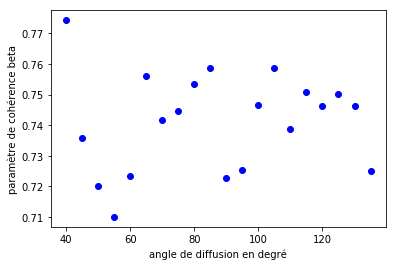

In [162]:
print("Beta = %f +/- %f" % (np.mean(Beta), np.std(Beta)))
plt.plot(angle, Beta, "bo")
plt.xlabel("angle de diffusion en degré")
plt.ylabel("paramètre de cohérence beta")
plt.savefig("beta_vs_theta.png", dpi=300)

## Analyse des courbes de correlations

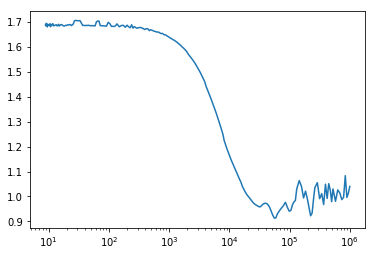

In [152]:
# os.chdir(r'C:\Users\MatthieuL\Documents\data\2018_05_24 deuxieme Calibration DLS\Arg')
# os.chdir(r'C:\Users\MatthieuL\Documents\data\2018_05_24 deuxieme Calibration DLS\Or')
os.chdir(r'C:\Users\MatthieuL\Documents\data\2018_05_24 deuxieme Calibration DLS\Fluo_3xdilue')


rawdata_correl = np.loadtxt("correation_curve.txt")
rawdata_correl = np.transpose(rawdata_correl)
time_axis = rawdata_correl[0]
correl_40 = rawdata_correl[1]
correl_50 = rawdata_correl[7]
correl_90 = rawdata_correl[10]

start_idx = 20

correl_50 = correl_50[start_idx:]
correl_90 = correl_90[start_idx:]
time_axis = time_axis[start_idx:]

plt.semilogx(time_axis, correl_90)

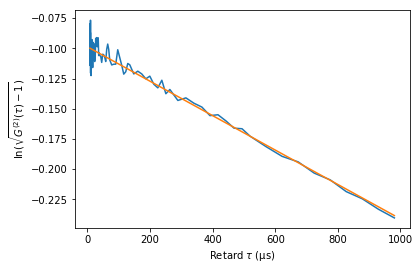

In [153]:
from lmfit.models import LinearModel

idx_strip = 100
correl_50_strip = correl_50[:-idx_strip]
time_axis_strip = time_axis[:-idx_strip]

dls_fit_qty = np.log(np.sqrt(correl_50_strip-1))
plt.plot(time_axis_strip, dls_fit_qty)

line_fit = LinearModel()
fit_result = line_fit.fit(dls_fit_qty, x=time_axis_strip, intercept=0, slope=-1)

plt.plot(time_axis_strip, fit_result.best_fit)
plt.xlabel(r"Retard $\tau$ (µs)")
plt.ylabel(r"$\ln (\sqrt{G^{(2)}(\tau) -1})$")

plt.savefig("polydisperse_l_ne_Au80.png", dpi=300)

# line2 = np.log(correl_50_strip-1)
# plt.plot(time_axis_strip, line2)

In [156]:
taus = time_axis
Gn = correl_90

# Il faudrait mieux ici utiliser pySPC et la fonction DLS, mais je n'ai pas le temps

def cumulant(t, B, beta, tau, mu2, mu3, mu4):
    return B + beta*np.exp(-t/tau)*((1 + mu2/2*t**2/tau**2 - mu3/6*t**3/tau**3 + mu4/24*t**4/tau**4)**2)

model = lmfit.Model(cumulant, nan_policy="propagate")
params = model.make_params(B=1, beta=0.7, tau=500, mu2=0, mu3=0, mu4=0)
# params['A0'].set(min=0.01, value=1)
params['mu2'].set(min=0, max=0.4, value=1e-3)


fitres = model.fit(Gn, t=taus, params=params)
print('\nList of fitted parameters for %s: \n' % model.name)
fitres.params.pretty_print(colwidth=10, columns=['value', 'min', 'max'])


fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                       gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(taus, Gn, "ro", alpha=0.5)
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3)
ax[0].plot(taus, fitres.best_fit, "b-", linewidth=3)
ax[1].plot(taus, fitres.residual, 'k')
ym = np.abs(fitres.residual).max()
ax[1].set_ylim(-ym, ym)
# ax[1].set_xlim(bins[0]*unit, bins[-1]*unit);
# tau_diff_us = fitres.values['tau_diff'] * 1e6
msg = ((r'$\beta$ = {A0:.2f}'+'\n'+r'$\tau$ = {tau_diff_us:.0f} μs' + '\n' + r'$\mu_2$ = {mu_2:.2f}')
       .format(A0=fitres.values['beta'], tau_diff_us=fitres.values['tau'], mu_2=fitres.values['mu2']))
ax[0].text(.75, .9, msg,
           va='top', ha='left', transform=ax[0].transAxes, fontsize=18);
ax[0].set_ylabel('G(τ)',  fontsize=40)
ax[1].set_ylabel('residuals', fontsize=20)
# ax[0].set_title('Donor-Acceptor CCF')
ax[1].set_xlabel('Retard, τ (µs)', fontsize=40)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=8)

ax[1].tick_params(axis='x', which='major', labelsize=20)
ax[1].tick_params(axis='x', which='minor', labelsize=8)

fig.savefig("fit_correlation_.png", cpdi=300)


List of fitted parameters for Model(cumulant): 

Name       Value        Min        Max
B          0.981       -inf        inf
beta      0.7164       -inf        inf
mu2    2.773e-13          0        0.4
mu3        0.296       -inf        inf
mu4       0.1546       -inf        inf
tau         8995       -inf        inf


In [60]:
print(np.searchsorted(angle, 90))

10


In [113]:
print(angle[10])
print(correlationTime[14])

70.0
213.257122


In [126]:
q_70 = 4 * np.pi * 1.33 / lambda_laser * np.sin(70*np.pi/180/2)
print(q_70)

D = 1/2*130*(1/q_70**2)

print(D)

print(radius_from_Stokes_Einstein(D))

15.149082679442715
0.28323093427654955
767.7038661315124
